In [58]:

#%% Delta
import geopandas as gpd
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

""" configuration """
folder = 'Permanent_water' # Permanent_water, Reservoirs
area = 'permanent_area' # permanent_area, seasonal_area
save_flag = True 

basin_level = 6 # basin level
alpha = 2 # mean +/- alpha * std
p_thd = 0.05

df = pd.DataFrame([], columns=['folder', 'area', 'basin_level', 'alpha', 'p_thd', 'num_of_masked_basins', 
                                'thd_low', 'thd_high', 'method', 'neg', 'stable', 'pos'])
df.to_csv(f'maps/{folder}_{area}.csv', mode='w')

# for alpha in [1, 1.5, 2, 2.5, 3]:
#     for p_thd in [0.01, 0.02, 0.025, 0.05]:

print()
print(f"----------------------- alpha: {alpha}, p_thd: {p_thd} --------------------------------------")

""" delta """
delta = pd.read_csv(f"outputs_delta/{folder}/{area}/basins_level_{basin_level}_ts_delta.csv")
delta = delta[delta['start_year']==2017]

delta['PFAF_ID'] = delta['id_bgl'].transform(lambda id: eval(id.split("_")[0]))
delta['Country_ID'] = delta['id_bgl'].transform(lambda id: eval(id.split("_")[-1]))
# delta = delta[(delta['Country_ID'] == Country_ID)]  
# df.set_index('PFAF_ID').dropna().to_csv(f'outputs_map/{folder}_basins_level_6_delta.csv')

""" delta thresholds """
df_thd = pd.read_csv(f"outputs_delta/{folder}/{area}/basin_level_mean_std.csv").set_index('basin_level')
mean = df_thd[f'mean_{area}'].loc[basin_level]
std = df_thd[f'std_{area}'].loc[basin_level]
print(f"mean: {mean}, std: {std}")

thd_low = mean - alpha * std 
thd_high = mean + alpha * std 
print(f"thd_low: {thd_low}, thd_high: {thd_high}")

def get_sign(x):
    if x < thd_low: return -1.0
    if x > thd_high: return 1.0
    return 0.0

delta['sign'] = delta[area].transform(get_sign)

#%% U-TEST

def get_u_sign(delta_value):
    if delta_value < 0: return -1
    elif delta_value > 0: return 1
    else: return 0

# p_thd = 0.05
# min_area_thd = 0.01 
u_test = pd.read_csv(f"outputs_utest/{folder}/{area}/basins_level_{basin_level}_utest.csv")
u_test['u_flag'] = u_test['p_u'].transform(lambda x: float(x < p_thd)) # u_flag determines whether a basin change or not

# u_test['u_sign'] = u_test['delta'].transform(lambda x: get_u_sign(x))
# u_test['u_sign'][u_test['baseline_median'] < min_area_thd] = -99
u_test['u_sign'][u_test['u_sign'] == -99] = 0
u_test['u_sign'] = u_test['u_sign'] * u_test['u_flag']

if 'id' in u_test.columns: u_test = u_test.rename(columns={'id': 'id_bgl'})

u_test['PFAF_ID'] = u_test['id_bgl'].transform(lambda id: eval(id.split("_")[0]))
# u_test['u_sign'] = u_test['u_score'].transform(lambda x:  np.round(x / (abs(x) + 1e-3))) * u_test['u_sign']
u_test = u_test.rename(columns={'id': 'id_bgl'})
# df.set_index('PFAF_ID').dropna().to_csv(f'outputs_map/{folder}/basins_level_6_utest_p_thd_0_01.csv')
# u_test

#%% Merge DataFrame

""" merge delta and utest """
delta_u = pd.merge(delta, u_test, on='id_bgl')
delta_u = delta_u.rename(columns={'PFAF_ID_x': 'PFAF_ID'})

# apply delta based mask on utest
delta_u['delta_mask'] = 1
delta_u['delta_mask'][(thd_low <= delta_u['delta']) & (delta_u['delta'] <= thd_high)] = 0
delta_u['u_sign'] = delta_u['u_sign'] * delta_u['delta_mask']

num_before_basin_masking = delta_u.shape[0]
print(f"before applying masked_basins: {num_before_basin_masking}")

masked_basins = gpd.read_file("data\Masked__basins\SNow_Arid_Mask.shp")
masked_basins['PFAF_ID_6'] = masked_basins['PFAF_ID_6'].transform(lambda x: eval(x))
delta_u = delta_u[~delta_u['PFAF_ID'].isin(masked_basins['PFAF_ID_6'].unique())]
# delta_u

print(f"after applying masked_basins: {delta_u.shape[0]}")
num_of_masked_basins = num_before_basin_masking - delta_u.shape[0]
print(f"number of masked basins: {num_of_masked_basins}")


----------------------- alpha: 2, p_thd: 0.05 --------------------------------------
mean: -0.768410471435599, std: 14.397894467900349
thd_low: -29.564199407236295, thd_high: 28.0273784643651
before applying masked_basins: 19163
after applying masked_basins: 13893
number of masked basins: 5270


In [57]:
print(df_thd[f'mean_{area}'].loc[basin_level])
print(df_thd[f'std_{area}'].loc[basin_level])

print(df_thd[f'mean_{area}'])


-0.0857345316429409
1.753821090649771
basin_level
0    0.219480
3   -0.096246
4   -0.226419
5   -0.131699
6   -0.085735
7   -0.020199
8   -0.000777
Name: mean_permanent_area, dtype: float64


total_number_basins = 19163
p_th: 0.01, numer of changed basins: 637, percentage: 3.32%
p_th: 0.02, numer of changed basins: 889, percentage: 4.64%
p_th: 0.025, numer of changed basins: 1029, percentage: 5.37%
p_th: 0.05, numer of changed basins: 1357, percentage: 7.08%
p_th: 0.1, numer of changed basins: 1661, percentage: 8.67%


<Axes: title={'center': 'p_u/Reservoirs/permanent_area'}, ylabel='Frequency'>

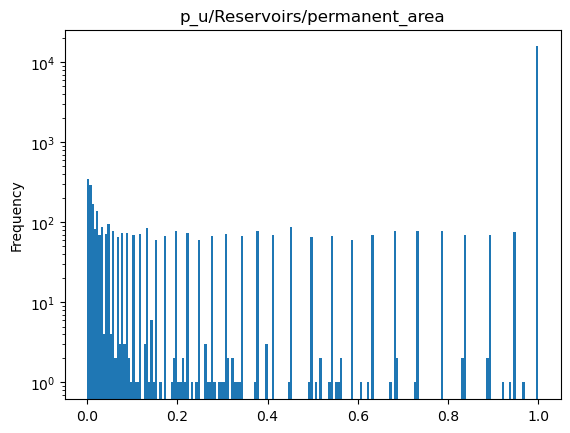

In [45]:
print(f'total_number_basins = {u_test.shape[0]}')
for p_th in [0.01, 0.02, 0.025, 0.05, 0.1]:
    num_of_change_basins = u_test[u_test['p_u'] < p_th].shape[0]
    print(f"p_th: {p_th}, numer of changed basins: {num_of_change_basins}, percentage: {num_of_change_basins / u_test.shape[0] *100:.2f}%")

u_test['p_u'].plot(kind='hist', bins=200, logy=True, title=f'p_u/{folder}/{area}')

<Axes: ylabel='Frequency'>

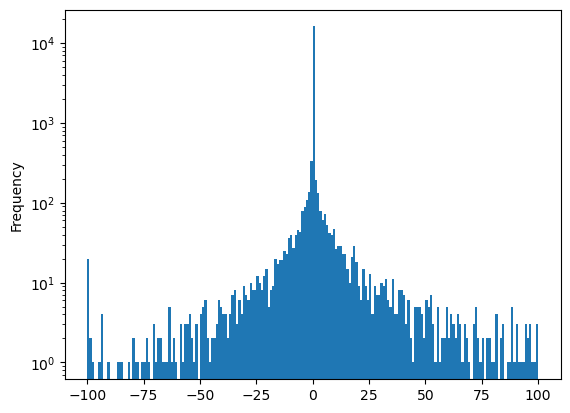

In [46]:

delta[delta[area] < 100][area].plot(kind='hist', bins=200, logy=True)

<Axes: ylabel='Frequency'>

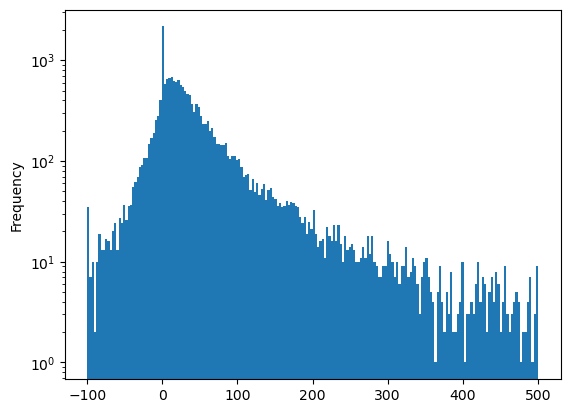

In [35]:
delta[delta[area] < 500][area].plot(kind='hist', bins=200, logy=True)

In [33]:
delta[delta[area] < 500].describe()

,start_year,basin_level,seasonal_area,PFAF_ID,Country_ID,sign
count,18215.0,18215.0,18215.000000,18215.000000,18215.000000,18215.000000
mean,2017.0,6.0,45.025099,434593.860280,405.992094,0.272632
std,0.0,0.0,75.380838,230848.086296,285.552477,0.481918
min,2017.0,6.0,-100.000000,111011.000000,4.000000,-1.000000
25%,2017.0,6.0,1.839306,227208.500000,124.000000,0.000000
50%,2017.0,6.0,23.262341,434694.000000,398.000000,0.000000
75%,2017.0,6.0,58.441324,631040.000000,643.000000,1.000000
max,2017.0,6.0,499.988432,999999.000000,1098.000000,1.000000


In [31]:
cut = 100
# 2.7263803080211018	23.98469613362817


print('mean', delta[(delta[area] < cut) & (delta[area] > -cut)][area].mean())
print('std', delta[(delta[area] < cut) & (delta[area] > -cut)][area].std())


mean 21.4147691405505
std 31.48910335147447
mean 21.4147691405505
std 31.48910335147447


In [20]:
delta[(delta[area] < 100) & (delta[area] > -100)][area].mean()

1.7589873796749584